In [1]:
from pathlib import Path
import urllib.request
import pandas as pd

url = 'https://s3.amazonaws.com/datashader-data/nyc_taxi_wide.parq'
dfile = Path('large-data/nyc_taxi_wide.parq')
if not dfile.is_file():
    urllib.request.urlretrieve(url, dfile)

usecols = ['dropoff_x','dropoff_y','pickup_x','pickup_y',
           'dropoff_hour','pickup_hour','passenger_count',
           'tpep_pickup_datetime', 'tpep_dropoff_datetime']

df = pd.read_parquet(dfile, engine='fastparquet')[usecols]
df['weekday'] = df['tpep_pickup_datetime'].dt.dayofweek
df.head()

dropoff_x  dropoff_y   pickup_x   pickup_y  dropoff_hour  pickup_hour  \
0 -8234835.5  4975627.0 -8236963.0  4975552.5            19           19   
1 -8237020.5  4976875.0 -8237826.0  4971752.5            20           20   
2 -8232279.0  4986477.0 -8233561.5  4983296.5            20           20   
3 -8238124.0  4971127.0 -8238654.0  4970221.0            20           20   
4 -8238107.5  4974457.0 -8234433.5  4977363.0            20           20   

   passenger_count tpep_pickup_datetime tpep_dropoff_datetime  weekday  
0                1  2015-01-15 19:05:39   2015-01-15 19:23:42        3  
1                1  2015-01-10 20:33:38   2015-01-10 20:53:28        5  
2                1  2015-01-10 20:33:38   2015-01-10 20:43:41        5  
3                1  2015-01-10 20:33:39   2015-01-10 20:35:31        5  
4                1  2015-01-10 20:33:39   2015-01-10 20:52:58        5

In [2]:
pickup_hour_counts = df.groupby('pickup_hour').size()

In [3]:
pickup_hour_counts

pickup_hour
0     422395
1     318624
2     241031
3     176482
4     123661
5     106368
6     237927
7     423407
8     531625
9     551687
10    539556
11    567284
12    604782
13    599189
14    614862
15    602741
16    535178
17    626922
18    753750
19    756882
20    683381
21    657564
22    629954
23    536842
dtype: int64

Since our data is large, and we are interested in planning, its a good idea to group by pickup hour and cluster independently for different hours. Lets choose 18, as it is the end of shift for most people. We still get around a million points.

In [4]:
df_18 = df[(df.pickup_hour == 18) & (df.weekday < 5)][['pickup_x', 'pickup_y']]
len(df_18)

537710

Lets first visualize the density with datashader, we would like a plot per hour eventually, for weekdays, weekends as well.

In [5]:
df.tpep_pickup_datetime.max()

Timestamp('2015-01-31 23:59:59')

In [6]:
df.tpep_pickup_datetime.min()

Timestamp('2015-01-01 00:00:00')

For monthly rides, we define a minimum cluster size as to have at least 100 rides.

In [7]:
df_18['pickup_y'].max()

4988749.5

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
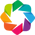

In [8]:
import holoviews as hv
from holoviews.element.tiles import OSM
from holoviews.operation.datashader import datashade, dynspread
import colorcet as cc
import datashader as ds

hv.extension('bokeh')

In [9]:
x_range, y_range =(-8242000,-8220000), (4966000,4986000)
colors = ["#FF0000","#FF3F00","#FF7F00","#FFBF00","#FFFF00","#BFFF00","#7FFF00","#3FFF00",
          "#00FF00","#00FF3F","#00FF7F","#00FFBF","#00FFFF","#00BFFF","#007FFF","#003FFF",
          "#0000FF","#3F00FF","#7F00FF","#BF00FF","#FF00FF","#FF00BF","#FF007F","#FF003F"]
tiles = OSM().opts(alpha=0.5, width=900, height=500).redim.range(x=x_range, y=y_range)
points = hv.Points(df, ['pickup_x', 'pickup_y'])
shader = datashade(points, color_key=colors, normalization='eq_hist', aggregator=ds.count_cat('pickup_hour'))
tiles * dynspread(shader, threshold=0.3, max_px=4)

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [pickup_x,pickup_y]   (R,G,B,A)

In [10]:
from datashader.colors import Hot

x_range, y_range =(-8242000,-8220000), (4966000,4986000)
tiles = OSM().opts(alpha=0.5, width=900, height=500).redim.range(x=x_range, y=y_range)
points = hv.Points(df, ['pickup_x', 'pickup_y'])
shader = datashade(points, cmap=Hot, normalization='eq_hist')
tiles * dynspread(shader, threshold=0.3, max_px=4)

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [pickup_x,pickup_y]   (R,G,B,A)

To perform clustering we have two options, work in radians and use the great circle distance, which is more natural, or project onto UTM and use coordinates in meters, which makes the parameters easier to interpret. We will project into UTM, as working in meters should also be faster, as euclidian distance is faster to compute than the great circle distance.

Alternatively, try using radians, since the conversion is easy.

In [11]:
df.head()

dropoff_x  dropoff_y   pickup_x   pickup_y  dropoff_hour pickup_hour  \
0 -8234835.5  4975627.0 -8236963.0  4975552.5            19          19   
1 -8237020.5  4976875.0 -8237826.0  4971752.5            20          20   
2 -8232279.0  4986477.0 -8233561.5  4983296.5            20          20   
3 -8238124.0  4971127.0 -8238654.0  4970221.0            20          20   
4 -8238107.5  4974457.0 -8234433.5  4977363.0            20          20   

   passenger_count tpep_pickup_datetime tpep_dropoff_datetime  weekday  
0                1  2015-01-15 19:05:39   2015-01-15 19:23:42        3  
1                1  2015-01-10 20:33:38   2015-01-10 20:53:28        5  
2                1  2015-01-10 20:33:38   2015-01-10 20:43:41        5  
3                1  2015-01-10 20:33:39   2015-01-10 20:35:31        5  
4                1  2015-01-10 20:33:39   2015-01-10 20:52:58        5

We first need lat lon.

In [12]:
from pyproj import Transformer

# Original projection: epsg:3857 (Web Mercator)
# Lat-lon projection: epsg:4326

transformer = Transformer.from_crs(3857, 4326)

df["pickup_lat"], df["pickup_lon"] = transformer.transform(df['pickup_x'], df['pickup_y'])
#df['pickup_x_rad'] = np.radians(df['pickup_x'])

In [13]:
df['pickup_x_rad'] = np.radians(df['pickup_lon'])
df['pickup_y_rad'] = np.radians(df['pickup_lat'])
df.head()

dropoff_x  dropoff_y   pickup_x   pickup_y  dropoff_hour pickup_hour  \
0 -8234835.5  4975627.0 -8236963.0  4975552.5            19          19   
1 -8237020.5  4976875.0 -8237826.0  4971752.5            20          20   
2 -8232279.0  4986477.0 -8233561.5  4983296.5            20          20   
3 -8238124.0  4971127.0 -8238654.0  4970221.0            20          20   
4 -8238107.5  4974457.0 -8234433.5  4977363.0            20          20   

   passenger_count tpep_pickup_datetime tpep_dropoff_datetime  weekday  \
0                1  2015-01-15 19:05:39   2015-01-15 19:23:42        3   
1                1  2015-01-10 20:33:38   2015-01-10 20:53:28        5   
2                1  2015-01-10 20:33:38   2015-01-10 20:43:41        5   
3                1  2015-01-10 20:33:39   2015-01-10 20:35:31        5   
4                1  2015-01-10 20:33:39   2015-01-10 20:52:58        5   

   pickup_lat  pickup_lon  pickup_x_rad  pickup_y_rad  
0   40.750110  -73.993898     -1.291437      0.711224  
1   40.724245  -74.001650     -1.291572      0.710772  
2   40.802789  -73.963341     -1.290904      0.712143  
3   40.713817  -74.009088     -1.291702      0.710590  
4   40.762430  -73.971175     -1.291041      0.711439

In [14]:
df_18 = df[(df.pickup_hour == 18) & (df.weekday < 5)][['pickup_x_rad', 'pickup_y_rad']]

It seems we need UTM anyway, since haversine distance breaks for many points.

In [15]:
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

minx, miny, maxx, maxy = min(df['pickup_lon']), min(df['pickup_lat']), max(df['pickup_lon']), max(df['pickup_lat'])
x_center = np.mean([minx, maxx])
y_center = np.mean([miny, maxy])

utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=x_center,
            south_lat_degree=y_center,
            east_lon_degree=x_center,
            north_lat_degree=y_center,
        ),
)

utm_crs_list

[CRSInfo(auth_name='EPSG', code='32618', name='WGS 84 / UTM zone 18N', type=<PJType.PROJECTED_CRS: 'PROJECTED_CRS'>, deprecated=False, area_of_use=AreaOfUse(west=-78.0, south=0.0, east=-72.0, north=84.0, name='Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.'), projection_method_name='Transverse Mercator')]

In [16]:
utm_crs_list[0].code

'32618'

In [17]:
transformer = Transformer.from_crs(3857, 32618, always_xy=True)
df["pickup_x_utm"], df["pickup_y_utm"] = transformer.transform(df['pickup_x'], df['pickup_y'])
df.head()

dropoff_x  dropoff_y   pickup_x   pickup_y  dropoff_hour pickup_hour  \
0 -8234835.5  4975627.0 -8236963.0  4975552.5            19          19   
1 -8237020.5  4976875.0 -8237826.0  4971752.5            20          20   
2 -8232279.0  4986477.0 -8233561.5  4983296.5            20          20   
3 -8238124.0  4971127.0 -8238654.0  4970221.0            20          20   
4 -8238107.5  4974457.0 -8234433.5  4977363.0            20          20   

   passenger_count tpep_pickup_datetime tpep_dropoff_datetime  weekday  \
0                1  2015-01-15 19:05:39   2015-01-15 19:23:42        3   
1                1  2015-01-10 20:33:38   2015-01-10 20:53:28        5   
2                1  2015-01-10 20:33:38   2015-01-10 20:43:41        5   
3                1  2015-01-10 20:33:39   2015-01-10 20:35:31        5   
4                1  2015-01-10 20:33:39   2015-01-10 20:52:58        5   

   pickup_lat  pickup_lon  pickup_x_rad  pickup_y_rad   pickup_x_utm  \
0   40.750110  -73.993898     -1.291437      0.711224  584934.173480   
1   40.724245  -74.001650     -1.291572      0.710772  584312.360513   
2   40.802789  -73.963341     -1.290904      0.712143  587444.628700   
3   40.713817  -74.009088     -1.291702      0.710590  583697.255255   
4   40.762430  -73.971175     -1.291041      0.711439  586836.413913   

   pickup_y_utm  
0  4.511504e+06  
1  4.508626e+06  
2  4.517382e+06  
3  4.507461e+06  
4  4.512894e+06

In [18]:
import hdbscan

In [19]:
from collections import Counter

In [20]:
import matplotlib.pyplot as plt

In [21]:
df_18 = df[(df.pickup_hour == 18) & (df.weekday < 5)][['pickup_x_rad', 'pickup_y_rad']]

epsilon = 5 # calculate 5 meter epsilon threshold

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=200, cluster_selection_method = 'eom')
#cluster_selection_epsilon=epsilon, cluster_selection_method = 'eom')
clusterer.fit(df_18)
cluster_sizes = Counter(clusterer.labels_)
len(cluster_sizes)

363

In [22]:
len(cluster_sizes)/len(df_18)

0.0006750850830373249

In [23]:
df_18 = df[(df.pickup_hour == 18) & (df.weekday < 5)].copy()
df_18['labels'] = clusterer.labels_

In [24]:
x_range, y_range =(-8242000,-8220000), (4966000,4986000)
colors = ["#FF0000","#FF3F00","#FF7F00","#FFBF00","#FFFF00","#BFFF00","#7FFF00","#3FFF00",
          "#00FF00","#00FF3F","#00FF7F","#00FFBF","#00FFFF","#00BFFF","#007FFF","#003FFF",
          "#0000FF","#3F00FF","#7F00FF","#BF00FF","#FF00FF","#FF00BF","#FF007F","#FF003F"]*21
tiles = OSM().opts(alpha=0.5, width=900, height=500).redim.range(x=x_range, y=y_range)
points = hv.Points(df_18, ['pickup_x', 'pickup_y'])
shader = datashade(points, color_key=colors, normalization='eq_hist', aggregator=ds.count_cat('labels'))
tiles * dynspread(shader, threshold=0.3, max_px=4)

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [pickup_x,pickup_y]   (R,G,B,A)

To visualize the clusters we will find their convex hull.

In [25]:
# Get larger cluster to test convex hull routine
cluster_sizes.most_common()[1]

(241, 8361)

In [26]:
from shapely.geometry import MultiPoint

In [27]:
df_18[df_18.labels == 107][['pickup_x', 'pickup_y']].values[:10]

array([[-8238548.5,  4973785. ],
       [-8238558.5,  4973942.5],
       [-8238550. ,  4973975. ],
       [-8238560.5,  4973827. ],
       [-8238551. ,  4973825. ],
       [-8238553. ,  4973755. ],
       [-8238551. ,  4973925.5],
       [-8238549.5,  4973695. ],
       [-8238545. ,  4973910. ],
       [-8238553.5,  4973899.5]], dtype=float32)

In [28]:
mp = MultiPoint(df_18[df_18.labels == 107][['pickup_x', 'pickup_y']].values)

In [29]:
np.ravel(mp.convex_hull.centroid.xy)

array([-8238548.51410101,  4973857.07211421])

In [30]:
c_hulls = []
polys = []
centroids = []
for k in np.unique(clusterer.labels_):
    if k == -1: continue
    hull = MultiPoint(df_18[df_18.labels == k][['pickup_x', 'pickup_y']].values).convex_hull
    centroids.append(np.ravel(hull.centroid.xy))
    x, y = hull.exterior.xy
    polys.append({'x': x, 'y': y, 'value': k})
    c_hulls.append(hull)

In [31]:
len(c_hulls)

362

In [32]:
x_range, y_range =(-8242000,-8220000), (4966000,4986000)
tiles = OSM().opts(alpha=0.5, width=900, height=500).redim.range(x=x_range, y=y_range)
points = hv.Points(df_18[df_18.labels != -1], ['pickup_x', 'pickup_y'])
points.opts(color='k')
polys1 = hv.Polygons(polys)
shader = datashade(points, cmap=Hot)
tiles * polys1 * points

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [x,y]
   .Points.I   :Points   [pickup_x,pickup_y]   (dropoff_x,dropoff_y,dropoff_hour,pickup_hour,passenger_count,tpep_pickup_datetime,tpep_dropoff_datetime,weekday,pickup_lat,pickup_lon,pickup_x_rad,pickup_y_rad,pickup_x_utm,pickup_y_utm,labels)

In [33]:
from alphashape import alphashape

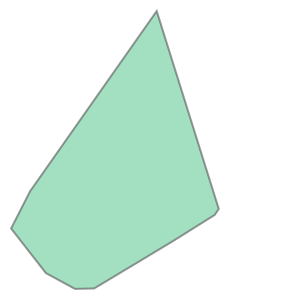

In [34]:
c_hulls[0]

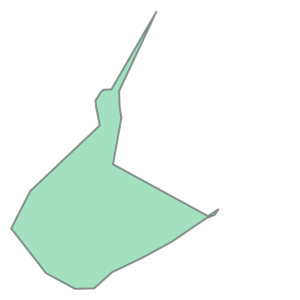

In [35]:
mp = MultiPoint(df_18[df_18.labels == 0][['pickup_x', 'pickup_y']].values)
ash = alphashape(mp, alpha=0.004)
ash

In [36]:
len(mp)

441

In [37]:
from alphashape import optimizealpha

In [39]:
%%time
optimizealpha(mp, upper=1, silent=True)

CPU times: user 5.07 s, sys: 31.7 ms, total: 5.1 s
Wall time: 5.08 s


0.004032451679122584